# Barnes-Hut Algorithm

In previous worksheets, we discussed a list based algorithm for short range forces. In next two worksheets, we will study tree based algorithms for the pairwise force calculation of long range forces. The Barnes-Hut algorithm is the first tree based algorithm that we will discuss.

In previous methods (Verlet-lists and Linked List methods), we ignored the particles that were far away (beyond the cut off radius $r_c$), which is only reasonable for forces that rapidly converge to zero.

## Example: Gravity
If we want to calulate the gravitational force other planets exert on earth, then the force applied by a single planet of an other galaxy (other than milky way) may not be considerable. However, the total force applied by the whole galaxy can be considerable.

The trick to reduce the complexity of this calculation is to consider the distant cluster of particles as a single entity. In 1986, Barnes and Hut observed that the particles might work in the same way that humans interact with neighboring individuals, more distant villages and larger countries. They came up with an algorithm that the potential on an individual particle from other particles close by is evaluated by direct summation (particle-particle interaction), whereas the potential due to more distant particles is calculated by particle-cluster interaction. To apply this algorithm, they proposed a tree structure to group the particles in a smart way to facilitate the tree algorithm. Let's follow their idea to construct a tree of particles!

Here, we demonstrate the idea with a 2D quadtree where each cell can be subdivided into 4 child cells. We begin with a root cell which is big enough to contain all the particles in the domain. Then, we follow these rules to build the quadtree:
- If there is more than or equal to $n_{crit}$ particles in the cell, we need to split the current cell cell into 4 child cells.
- If there are less that $n_{crit}$ particle in the cell, the cell is left as it is. We call such cells **leaf** cells.
- If there is no particles in a cell, we can ignore the cell (do not store the cell in memory).

For the following figure let $n_{crit}=2$.

<p align="center">
<img src="./figures/tree_construct.png"
     alt="Tree construct"
     width="800" height="800"/>
</p>

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams, patches
import time
from tqdm import tqdm
from tabulate import tabulate

ModuleNotFoundError: No module named 'tabulate'

Following is the implementation of class __Particles__, similar as in previous worksheets

In [2]:
class Particle:

    """The derived class for a particle, inheriting the base class "Point".
    
    Attributes:
        m: mass of the particle.
        phi: the gravitational potential of the particle.
    """

    def __init__(self, coords=None, domain = 1, m=1.0):
        self.m = m
        self.phi = 0.
        if coords is None:
            self.x = domain * np.random.random()
            self.y = domain * np.random.random()
        else:
            assert len(coords) == 2, "Coordinates should be 2D"
            self.x = coords[0]
            self.y = coords[1]

    def plot(self, s=10):
        plt.scatter(self.x, self.y, marker='o', color='r', s=s)

    def distance(self, other):
        return np.sqrt((self.x-other.x)**2 + (self.y-other.y)**2)

## Building the Tree

The First step to implement Barnes-Hut is to build the tree. For this, we first define a class cell as described below.

We use an object-oriented approach. For those who have not been exposed to object-oriented programming in python, check out some guides e.g. [this one](https://www.tutorialspoint.com/python/python_classes_objects.htm).

## Defining the class ***Cell***

To start things off, we define a class `Cell`, which encapsulates properties like the cell's center coordinates, its parent, children, and indices of particles inside if it's a leaf. We will then create a list called `list_cells` comprising of all cells in the tree. The root cell shall be `list_cells[0]`.

<p align="center">
<img src="./figures/cell_class.png"
     alt="Cell class"
     width="512" height="512"/>
</p>
Let us go through some other terms in the figure above and other related terms:

- ***x_c, y_c, z_c, r_c***: center coordinates and side length of the cell.
- ***Root cell***: The first (=largest) cell that has no parent
- ***Leaf cell***: Cells that have no children
- ***Critical number of particles ($n_{crit}$)***: Threshold for splitting a cell into smaller ones.
- ***nparticles***: Number of particels in a cell.
- ***particle_index***: List of particle indices which are in this cell.
- ***parent***: Cell index of the parent cell.
- ***child_index***: List of cell indices of which are children of this cell.
- ***nchild***: It is a 4-bit binary number, each digit represents one of the four child quadrants. `1` denotes non-empty child cell, and `0` denotes empty child cell in that quadrant. For example: `nchild=0101` means the current cell only has non-empty children in the first and third quadrant.



In [3]:
class Cell:

    """The class for a cell.
    
    Arguments:
        n_crit: maximum number of particles in a leaf cell.
    
    Attributes:
        nparticles (int): number of particles in the cell
        particle_index (array of int): array of leaf index
        nchild (int):  an integer whose last 8 bits is used to keep track 
        of the empty child cells
        child_index (array of int): array of child index
        parent (int): index of parent cell
        x, y (float): coordinates of the cell's center
        r (float): radius of the cell (half of the side length for cubic cell)      
    """

    def __init__(self, n_crit, center, radius):
        self.nparticles = 0                                  # number of particels
        self.particle_index = np.zeros(n_crit, dtype=int)    # array of particle indices
        self.nchild = 0                                      # binary counter to keep track of empty cells
        self.child_index = np.zeros(4, dtype=int)            # array of child index
        self.parent = 0                                      # index of parent cell
        self.x = center[0]
        self.y = center[1]                                   # center of the cell
        self.r = radius                                      # radius of the cell
        self.level = 0

    def distance(self, other):
        """Helper function to get the distance between this and another cell's center.
        
        Arguments:
            other: Other cell.
        """
        return np.sqrt((self.x-other.x)**2 + (self.y-other.y)**2)

    def plot(self, n_crit, linewidth=1, color='k'):
        if self.nparticles >= n_crit:
            plt.hlines(self.y, self.x - self.r, self.x + self.r, linewidth=linewidth, color=color)
            plt.vlines(self.x, self.y - self.r, self.y + self.r, linewidth=linewidth, color=color)

### Creating a child

Let, $n_{crit} = 10$ <br/>
Assuming that we create the root cell, then we add the particles into this root cell. After we put the 10th particle into the root, `nparticles == n_crit == 10`. If there is a 11th particle coming, we have to split the root cell. For this, we create new intances of `Cell` which are the children of the root cell. Thus, `split_cell` will have to call `add_child`. So let's think about how to add a child.

To begin with, we need to append a new element to the cells list, so now the last element of the cells list should be the new child. First let's find the geometrical relationship between a parent $p$ and its child $c$:
- $r_{child}$ = $\frac{1}{2}r_{parent}$ for a cubic cell
- $x_{c}$, $y_{c}$, the child's center coordinates, can be determined by its $quadrant$ and its parent's center coordinates $x_{p}$, $y_{p}$. Refer to the code below and reflect how it works.(***Hint***: you have to work through binary operators)

Next, we need to establish a reference between the parent and the child in the cells list. Consider a new child is created in the parent's $3th$ quadrant. We assign the new child's index to the parent by `parent.child_index[3]=index_child`, and assign the parent's index to the new child by `child.parent=index_parent`. Don't forget the 4-bit binary marker `nchild`. Since the new child is at $3th$ quadrant, the fourth digit from the right should be changed from "0" to "1". Recall that we always manipulate the binary number with bit shift.


In [4]:
def add_child(quadrant, p, list_cells, n_crit):

    """Add a cell to the end of cells list as a child of p, initialize the
    center and radius of the child cell c, and establish mutual reference
    between child c and parent p.
    
    Arguments:
        quadrant: reference to one of the four divisions in two dimensions.
        p: parent cell index in cells list.
        list_cells: the list of cells.
        n_crit: maximum number of particles in a leaf cell.
    """

    # geometric relationship between parent and child
    new_radius = list_cells[p].r / 2
    new_center_x = list_cells[p].x + new_radius * ((quadrant & 1) * 2 - 1)
    new_center_y = list_cells[p].y + new_radius * ((quadrant & 2) - 1)
    new_cell = Cell(n_crit, [new_center_x, new_center_y], new_radius)

    # create a new cell instance
    list_cells.append(new_cell)
    # the index of the new child is the end of list_cells
    c = len(list_cells) - 1

    # establish mutual reference in the cells list
    list_cells[c].parent = p
    list_cells[p].child_index[quadrant] = c
    list_cells[p].nchild = (list_cells[p].nchild | (1 << quadrant))
    list_cells[c].level = list_cells[p].level + 1

### Split a cell

Now, let's focus on splitting a cell. First we need to realize that `split_cell()` should be recursive because after splitting a cell there is a probability that all the particles are reallocated to the same child. In this scenario, we have to recursively split the child cell again until all the cells satisfy the rule $n_{crit}=10$.

Consider the case that we put more than $n_{crit}+1$ particles in the root cell. It is time to split the root. In addition to creating new child cells, we also have to "trickle" down these particles. We loop over the particles, and if there is no child cell in that particle's quadrant, we create one and insert the particle. If there already is a child cell, we just put this particle in that child. Finally, we check if the number of particles in that child reached $n_{crit}$. If yes, we split it recursively.

In [5]:
def split_cell(list_particles, p, list_cells, n_crit):

    """Loop in parent p's leafs and reallocate the particles to subcells.
    If a subcell has not been created in that quadrant, create one using add_child. 
    If the subcell c's leaf number exceeds n_crit, split the subcell c recursively.
    
    Arguments: 
        list_particles: the list of particles.
        p: parent cell index in cells list.
        list_cells: the list of cells.
        n_crit: maximum number of particles in a leaf cell.
    """

    # loop in the particles stored in the parent cell that you want to split
    for l in list_cells[p].particle_index:

        # finds the particle's quadrant
        quadrant = (list_particles[l].x > list_cells[p].x) + ((list_particles[l].y > list_cells[p].y) << 1)

        # if there is no child cell available for the quadrant create one
        if not list_cells[p].nchild & (1 << quadrant):
            add_child(quadrant, p, list_cells, n_crit)

        # reallocate the particle in the child cell
        c = list_cells[p].child_index[quadrant]
        list_cells[c].particle_index[list_cells[c].nparticles] = l
        list_cells[c].nparticles += 1

        # check if the child reach n_crit
        if list_cells[c].nparticles >= n_crit:
            split_cell(list_particles, c, list_cells, n_crit)

### Constructing the tree

Based on adding and splitting a cell, we can formulate our code to build the tree. We loop over the particles, and find a cell for each particle from top (root cell) to bottom (leaf cell). If the current cell where the particle lives is not a leaf cell, we recursively split it, traverse down until we find or create the leaf cell. Finally we can put every particle in a certain leaf cell where $n_{particels} \lt n_{crit}$. After we allocate every particle, we perform a check to determine whether the cell has to be split or not.

In [6]:
def build_tree(list_particles, root, n_crit):

    """Construct a hierarchical octree to store the particles and return
    the tree (list) of cells.

    Arguments:
        list_particles: the list of particles.
        root: the root cell.
        n_crit: maximum number of particles in a single cell.

    Returns:
        list_cells: the list of cells.

    """
    # set root cell
    list_cells = [root]

    # build tree
    for i in range(len(list_particles)):
        # traverse from the root down to a leaf cell
        curr = 0

        while list_cells[curr].nparticles >= n_crit:
            list_cells[curr].nparticles += 1
            quadrant = (list_particles[i].x > list_cells[curr].x) + ((list_particles[i].y > list_cells[curr].y) << 1)

            # if there is no child cell in the particle's quadrant, then create one
            if not list_cells[curr].nchild & (1 << quadrant):
                add_child(quadrant, curr, list_cells, n_crit)

            curr = list_cells[curr].child_index[quadrant]

        # allocate the particle in the leaf cell
        list_cells[curr].particle_index[list_cells[curr].nparticles] = i
        list_cells[curr].nparticles += 1

        # check whether to split or not
        if list_cells[curr].nparticles >= n_crit:
            split_cell(list_particles, curr, list_cells, n_crit)

    return list_cells

**Use what we implemented so far to generate a random scenario:**

In [7]:
domain_length = 1
n_crit = 4
num_particles = 50
# generate randomly distributed particles
particles = []
for i in range(num_particles):
    particles.append(Particle(domain=domain_length))
# Create a root cell
root = Cell(n_crit, center=[domain_length/2, domain_length/2], radius=domain_length/2)
# build the tree
cells = build_tree(particles, root, n_crit)

Let's plot the tree:

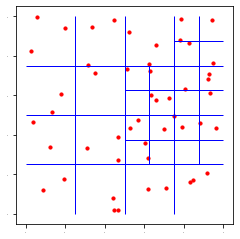

In [8]:
def plot_tree(particles, cells):
    fig = plt.figure()
    ax = plt.gca()
    for p in particles:
        p.plot()
    for c in cells:
        c.plot(n_crit, color='blue')
    ax.tick_params(axis='both',labelsize=0)
    ax.set_aspect('equal', adjustable='box')
    plt.show()

plot_tree(particles, cells)

Let us modify `n_crit` to a lower value and see how the tree changes.

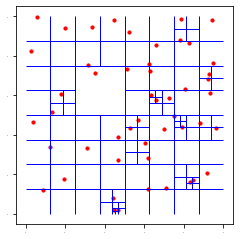

In [9]:
n_crit = 2
# build the tree
root_finer = Cell(n_crit, center=[domain_length/2, domain_length/2], radius=domain_length/2)
cells_finer = build_tree(particles, root_finer, n_crit)
# plot the tree
plot_tree(particles, cells_finer)

## Implementing the Barnes Hut Algorithm

In order to calculate the potential using the Barnes-Hut algorithm, we need to separate the near field particles and far-field clusters. For far field clusters, we accumulate the mass of all the particles at center of the cluster, then consider it as single particle and calculate the potential. The definition of far field is expressed in form of angle. Let us consider the following:
<p align="center">
<img src="./figures/barnes_hut.png"
     alt="Cell class"
     width="512" height="512"/>
</p>
For a particle $O$, the cluster is considered far if $\theta < \theta_{crititcal}$. As an intuition, $\theta$ is related to the angle the cluster takes up in the field of view of the particle. Meaning, the bigger or closer the cluster is, the larger this angle and hence $\theta$ becomes. Usually, $\theta$ is calculated as:
$$\theta \approx \frac{diameter}{distance} = \frac{d}{r}$$

If a cluster is not far, then we split the cell into its children as per the tree. We calculate the angle again for all children and continue to do so until, either we find a far field or we reach the a leaf cell. If we reach a leaf cell then we do the direct particle to particle interaction.

Firstly, we need to write a function which calculates the total mass of all the particles inside a cell. For that, we need to recursively go through each cell and its children until a leaf cell is reached.

### Task 1:
Implement the `get_mass` function which sums up the mass of all the particles inside the cell and returns the total mass.

In [10]:
# %load solution_task1_getMass.py
def get_mass(particles_list, cell_index, cells_list, n_crit):
    """Returns total mass of a cell
    Arguments:
    ---------
    particles_list : list
        List of all particles
    cell_index : int
        Index of cell whose mass we need to calculate
    cells_list : list
        List of all the cells in the tree
    n_crit : int
        Critical number of particles
    
    Return
    ------
    mass : Total mass of the cell
    """
    mass = 0
    com = np.zeros(2, dtype=float)
    ######### TODO BEGIN ###########

    cell = cells_list[cell_index]
    if cell.nparticles >= n_crit:                                # case: not leaf cell
        for child_index in cell.child_index:
            if child_index != 0:
                mass += get_mass(particles_list, child_index, cells_list, n_crit)
    else:                                                        # case: leaf cell
        for i in range(cell.nparticles):
            particle = particles_list[cell.particle_index[i]]    # this is a reference, not a copy
            mass += particle.m







    ########## TODO END ############
    return mass


### Task 2:

Implement the direct particle to particle interaction between one particle, given by its index, and all other particles.

In [11]:
# %load solution_task2_directInteraction.py
def direct_interaction(particle_index, particles_list, cell):
    """Direct particle to particle between particle and all the particles in leaf cell
    
    Arguments
    ---------
    particle_index : int
        index of particle whose potential we need to calculate potentail
    particles_list : list
        List of particles
    cell : object of type cell
        the leaf cell with which we want to do direct particle to particle interaction between the particle
        and all the particles in the leaf
    Return
    ------
    phi : float
        Potential generated by the cell on the particle
    num_evaluations : int
        Number of kernel evaluations
    """

    mass = particles_list[particle_index].m
    phi = 0.
    num_evaluations = 0
    ######## TODO Begin ##########
    for i in range(cell.nparticles):
        if particle_index != cell.particle_index[i]:              # prevent self interation
            distance = particles_list[cell.particle_index[i]].distance(particles_list[particle_index])
            phi += mass * particles_list[cell.particle_index[i]].m / distance
            num_evaluations += 1




    ######### TODO End ###########
    return phi, num_evaluations


### Task 3:

Implement the Barnes-Hut algorithm to calculate the potential exercted on a target particle, given by its index, from all the particles inside a cell, also given by its index. You should also take into account the contribution from all child cells. Hence, if applied with the root cell this function should calculate the full potential on the particle.

Hints if you get stuck:
1. Check if the source cell has less than `n_crit` particles. If yes, then perform direct potential calculation betwenn target particles and all the particles inside the source cell. Add the potential to phi and return phi
2. Calculate the parameter theta ($\theta$)
3. If $\theta \leq \theta_{critical}$ ($\theta_{critical}$ is represented be theta_limit), then calculate the total mass of the cell. Calculate the potential using the total mass and distance calculated(calculated between the particle and the center of the cell. It is calculated when you are finding the value of $\theta$) and add it to phi and then return phi
4. If $\theta > \theta_{critical}$, then go to all the child indices of the cell and check if the index of the child is not zero (think why are we doing that). If the index is not zero then we do recursion by calling the same function but with cell_index as index of child.
5. For simplification you can assume that all cells have their center of mass in their spatial center.

In [12]:
# %load solution_task3_barnesHut.py
def barnes_hut(particle_index, particles_list, cell_index, cells_list, n_crit, theta_limit=0.5, num_evaluations=0):
    """Barnes hut implementation to calculate the potential that is excerted on a particle from its
    interaction with a whole cell.
    
    Parameters
    -----------
    particle_index : int
        index of the particle in particles_list whose index we need to calculate
    particles_list : list
        List of particles
    cell_index : int
        Index of the cell whose effect we are going to calculate on concerned particle
    n_crit: int
        Number of particles above which we divide the cells into four child cells
    theta_limi: float (default value is 0.5)
        The limiting theta parameter for barnes hut algorithm
        
    Return
    ------
    phi: float
        the potential on a particle (whose index is provided) applied by all the particles inside 
        the cell (whose index is provided)
    num_evaluations : int
        Number of interaction evaluations
    """
    cell = cells_list[cell_index]
    particle = particles_list[particle_index]
    phi = 0.
    num_evaluations = 0
    ######## TODO Begin ##########


    if cell.nparticles < n_crit:                                             # case: leaf -> direct interaction
        phi, num_evaluations = direct_interaction(particle_index, particles_list, cell)
        return phi, num_evaluations

    distance = np.sqrt((cell.x - particle.x)**2 + (cell.y - particle.y)**2)  # case: not leaf cell
    theta = 2 * cell.r * np.sqrt(2) / distance
    if theta > theta_limit:                                                  # case: distant cell too big
        for i in cell.child_index:
            if i != 0:
                child_phi, child_evals = barnes_hut(particle_index, particles_list, i, cells_list, n_crit, theta_limit, num_evaluations)
                phi += child_phi
                num_evaluations += child_evals
    else:                                                                    # case: interact with whole cell
        mass = get_mass(particles_list, cell_index, cells_list, n_crit)
        phi += mass / distance
        if mass != 0:
            num_evaluations += 1














    ######### TODO End ###########
    return phi, num_evaluations


An implementation of the naive full direct interatcion for comparison:

In [13]:
# complete direct interaction
def naive_direct_interaction(particle_index, list_particles):
    phi = 0.
    for idx, p in enumerate(list_particles):
        if idx != particle_index:
            phi += list_particles[particle_index].m * p.m / p.distance(list_particles[particle_index])
    return phi, len(list_particles)

#### Evaluate the potential on all particles and compare the result on one particle.

Generating Particles: 100%|██████████| 1000/1000 [00:00<00:00, 499797.90it/s]


Building tree...
Plotting tree...


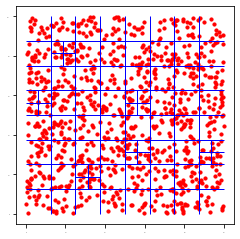

Running Algorithm: 100%|██████████| 1000/1000 [00:00<00:00, 1299.50it/s]

Relative mean squared root error BH (RMSRE):  0.007886855235729741
Relative root mean squared error BH (RRMSE):  2.564969002040502e-07


NameError: name 'tabulate' is not defined

In [14]:
def benchFun(f):
    """ Executes f for every particle and returns time and evaluation measuremtns

    :param f:
    :param potentials:
    :return: time_total, num_evals_total, potentials
    """
    num_evals_total = 0
    potentials = np.zeros(len(particles), dtype=float)
    start = time.time()
    for i in tqdm(range(len(particles)), desc="Running Algorithm"):
        potentials[i], num_evals_i = f(i)
        num_evals_total += num_evals_i
    stop = time.time()
    time_total = stop - start
    return time_total, num_evals_total, potentials

domain_length = 100
n_crit = 20
num_particles = 1000
# generate randomly distributed particles
particles = []
for i in tqdm(range(num_particles), desc="Generating Particles"):
    particles.append(Particle(domain=domain_length))
# build the tree
print("Building tree...")
rootX = Cell(n_crit, center=[domain_length/2, domain_length/2], radius=domain_length/2)
cellsX = build_tree(particles, rootX, n_crit)
# plot the tree
print("Plotting tree...")
plot_tree(particles, cellsX)

# run both algorithms
time_ds, num_evals_ds, potentials_ds = benchFun(lambda i : naive_direct_interaction(i, particles))
time_bh, num_evals_bh, potentials_bh = benchFun(lambda i : barnes_hut(i, particles, 0, cellsX, n_crit, theta_limit=1))

# calculate some error metrics
rmsre = math.sqrt(sum(((potentials_bh - potentials_ds) / potentials_ds)**2) / len(potentials_ds))
print("Relative mean squared root error BH (RMSRE): ", rmsre)
rrmse = math.sqrt((sum((potentials_bh - potentials_ds)**2) / len(potentials_bh))) / sum(potentials_ds**2)
print("Relative root mean squared error BH (RRMSE): ", rrmse)

# random particle whose force we want to compare
refId = 0
# print table of comparisons
print(tabulate([
                ['Potential[' + str(refId) + ']', potentials_ds[refId], potentials_bh[refId]],
                ['Time', time_ds, time_bh],
                ['Evaluations', num_evals_ds, num_evals_bh],
               ],
               headers=['Metric', 'Naive', 'Barnes-Hut'],
               tablefmt="fancy_grid")
      )


## Scaling and error plot

Now, let's observe how evaluation time and error changes when playing around with parameters like number of particles, critical angle ($\theta_{critical}$) and number of critical particles ($n_{crit}$).

In [15]:
number_particles = [100*i for i in range(1, 10)]
#number_particles = [10000]
barnes_hut_eval_time = np.zeros(len(number_particles), dtype=float)
naive_eval_time = np.zeros(len(number_particles), dtype=float)
num_evals_bh = np.zeros(len(number_particles), dtype=float)
num_evals_ds = np.zeros(len(number_particles), dtype=float)
n_crit = 20
theta_crit = 1
domain_length = 100
for idx, N in enumerate(tqdm(number_particles)):
    # create particles
    particles = []
    for i in range(N):
        particles.append(Particle())
    root = Cell(n_crit, center=[domain_length/2, domain_length/2], radius=domain_length/2)

    # build the tree
    cells = build_tree(particles, root, n_crit)
    potentials_bh = np.zeros(len(particles), dtype=float)
    potentials_ds = np.zeros(len(particles), dtype=float)
    # Calculate using BH
    barnes_hut_start = time.time()
    for i in range(len(particles)):
        potentials_bh[i], num_evals_bh_i = barnes_hut(i, particles, 0, cells, n_crit, theta_limit=theta_crit)
        num_evals_bh[idx] += num_evals_bh_i
    barnes_hut_end = time.time()
    barnes_hut_eval_time[idx] = barnes_hut_end - barnes_hut_start
    # Calculate using naive direct interaction
    naive_start = time.time()
    for i in range(len(particles)):
        potentials_ds[i], num_evals_ds_i = naive_direct_interaction(i, particles)
        num_evals_ds[idx] += num_evals_ds_i
    naive_end = time.time()
    naive_eval_time[idx] = naive_end - naive_start

100%|██████████| 9/9 [00:06<00:00,  1.40it/s]


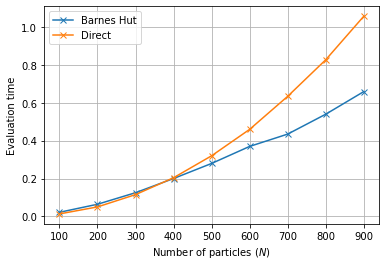

In [16]:
plt.plot(number_particles, barnes_hut_eval_time, label='Barnes Hut', marker='x')
plt.plot(number_particles, naive_eval_time, label='Direct', marker='x')
plt.ylabel('Evaluation time')
plt.xlabel('Number of particles ($N$)')
plt.legend()
plt.grid()
plt.show()

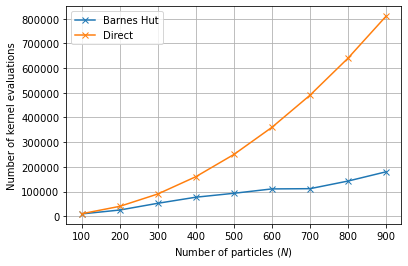

In [17]:
plt.plot(number_particles, num_evals_bh, label='Barnes Hut', marker='x')
plt.plot(number_particles, num_evals_ds, label='Direct', marker='x')
plt.ylabel('Number of kernel evaluations')
plt.xlabel('Number of particles ($N$)')
plt.legend()
plt.grid()
plt.show()

### Task 4

1. Plot error mean relative error for N=1000 particles, $\theta_{critical}$ with different $n_{crit} = [2, 5, 10, 15, 20]$
2. Plot error mean relative error for N=1000 particles, $n_{crit} = 5$ with different $\theta_{critical} = [0.1, 0.5, 1]$

Explain the behavior of the graphs

1. For different `n_crit`:

In [18]:
N = 1000
particles = []

# generate N random particles
for i in range(N):
    particles.append(Particle())
potentials_ds = np.zeros(len(particles), dtype=float)

# calculate the potential via direct sum for every particle
for i in tqdm(range(len(particles)), desc="Naive"):
    potentials_ds[i], _ = naive_direct_interaction(i, particles)

N_crit = [2,5,10,15,20]
barnes_hut_eval_time = np.zeros(len(N_crit), dtype=float)
naive_eval_time = np.zeros(len(N_crit), dtype=float)
theta_crit = 0.5
mean_error_n_crit = np.zeros(len(N_crit), dtype=float)
# calculate the potential via barnes hut and different n_crit
for idx, n_crit in enumerate(tqdm(N_crit, desc="Barnes-Hut")):
    root = Cell(n_crit, center=[0.5,0.5], radius=0.5)
    # build the tree
    cells = build_tree(particles, root, n_crit)
    potentials_bh = np.zeros(N, dtype=float)
    for i in range(len(particles)):
        potentials_bh[i], _ = barnes_hut(i, particles, 0, cells, n_crit, theta_limit=0.5)
    mean_error_n_crit[idx] = np.mean(np.abs((potentials_bh - potentials_ds) / potentials_ds))

Barnes-Hut: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


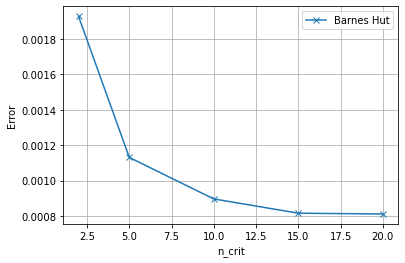

In [19]:
plt.plot(N_crit, mean_error_n_crit, label='Barnes Hut', marker='x')
plt.ylabel('Error')
plt.xlabel('n_crit')
plt.grid()
plt.legend()
plt.show()

For different $\theta_{critical}$:

In [20]:
N = 1000
particles = []

# generate N random particles
for i in range(N):
    particles.append(Particle())
potentials_ds = np.zeros(len(particles), dtype=float)

# calculate the potential via direct sum for every particle
for i in tqdm(range(len(particles)), desc="Naive"):
    potentials_ds[i], _ = naive_direct_interaction(i, particles)

n_crit = 5
Theta_crit = [0.1, 0.5, 1]
barnes_hut_eval_time = np.zeros(len(Theta_crit), dtype=float)
naive_eval_time = np.zeros(len(Theta_crit), dtype=float)
mean_error_theta = np.zeros(len(Theta_crit), dtype=float)
# calculate the potential via barnes hut and different n_crit
for idx, theta_crit in enumerate(tqdm(Theta_crit, desc="Barnes-Hut")):
    root = Cell(n_crit, center=[0.5,0.5], radius=0.5)
    # build the tree
    cells = build_tree(particles, root, n_crit)
    potentials_bh = np.zeros(N, dtype=float)
    for i in range(len(particles)):
        potentials_bh[i], _ = barnes_hut(i, particles, 0, cells, n_crit, theta_limit=theta_crit)
    mean_error_theta[idx] = np.mean(np.abs((potentials_bh - potentials_ds) / potentials_ds))

Barnes-Hut: 100%|██████████| 3/3 [00:05<00:00,  1.87s/it]


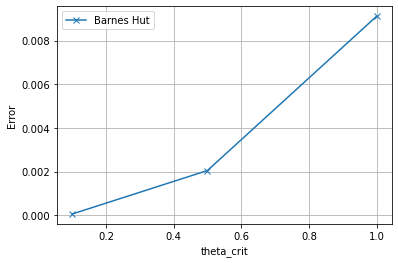

In [21]:
plt.plot(Theta_crit, mean_error_theta, label='Barnes Hut', marker='x')
plt.ylabel('Error')
plt.xlabel('theta_crit')
plt.grid()
plt.legend()
plt.show()